# Abstractive Text Summarization

[Post](https://towardsdatascience.com/data-scientists-guide-to-summarization-fc0db952e363) on getting started with `text summarization`, their pros and cons and much more.

**There 3 different training models used here**
- `build_seq2seq_model_with_just_lstm` - **Seq2Seq model with just LSTMs**. Both `encoder` and `decoder` have just `LSTM`s.
- `build_seq2seq_model_with_bidirectional_lstm` - **Seq2Seq model with Bidirectional LSTMs**. Both `encoder` and `decoder` have `Bidirectional LSTM`s.
- `build_hybrid_seq2seq_model` - **Seq2Seq model with hybrid architecture**. Here `encoder` has `Bidirectional LSTM`s while `decoder` has just `LSTM`s.

**To see the full learning and results of all the 3 model go to the end of the notebook in the `Running all the 3 different models` section**

The `model (the trained model)`, `encoder_model (for inference)` and `decoder_model (for inference)` for **Seq2Seq with just LSTMs** are only saved.



In [1]:
#import tensorflow

In [9]:
import os
import re
import pickle
import string
import unicodedata
from random import randint

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from wordcloud import STOPWORDS, WordCloud

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, TimeDistributed

2023-08-18 02:56:50.399561: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# !pip install -q contractions==0.0.48

In [3]:
from contractions import contractions_dict

for key, value in list(contractions_dict.items())[:10]:
    print(f'{key} == {value}')

I'm == I am
I'm'a == I am about to
I'm'o == I am going to
I've == I have
I'll == I will
I'll've == I will have
I'd == I would
I'd've == I would have
Whatcha == What are you
amn't == am not


In [4]:
# # Using TPU

# # detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)

# # instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

## 🪂 Getting the data

In [5]:
# #filename1 = '../input/news-summary/news_summary.csv'
# #filename2 = '../input/news-summary/news_summary_more.csv'

# df1 = pd.read_csv(filename1, encoding='iso-8859-1').reset_index(drop=True)
# df2 = pd.read_csv(filename2, encoding='iso-8859-1').reset_index(drop=True)

df = pd.read_csv('/home/mainaksen/Ankan/Text/df_cleaned.csv')

In [6]:
df.shape

(310951, 2)

In [7]:
df.sample(5)

,article,summary
241763,daily mail reporter publish est september upda...,justin valdez sophomore san francisco state un...
46903,senator jeff flake son young wife sue maricopa...,logan austin flake son senator jeff flake char...
226636,mia de graaf publish est october update est oc...,marcus daniel mclachlan bear weigh lb oz r cho...
258514,sam adams publish est july update est july emm...,talented writer three emmy award nominate anot...
227613,glamorous playthings multi millionaires usuall...,huge number foreign own sport cars x descend g...


The `headlines` column will be treated as `summary` for the text.

## 🏂 Data preparation

In [8]:
def expand_contractions(text, contraction_map=contractions_dict):
    # Using regex for getting all contracted words
    contractions_keys = '|'.join(contraction_map.keys())
    contractions_pattern = re.compile(f'({contractions_keys})', flags=re.DOTALL)

    def expand_match(contraction):
        # Getting entire matched sub-string
        match = contraction.group(0)
        expanded_contraction = contraction_map.get(match)
        if not expand_contractions:
            print(match)
            return match
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


expand_contractions("y'all can't expand contractions i'd think")

'you all can not expand contractions id think'

In [9]:
df.head()

,article,summary
0,sally forrest actress dancer grace silver scre...,sally forrest actress dancer grace silver scre...
1,middle school teacher china ink hundreds sketc...,work include picture presidential palace yangt...
2,man convict kill father sister former girlfrie...,iftekhar murtaza convict year ago kill ex girl...
3,avid rugby fan prince harry could barely watch...,prince harry attendance england crunch match f...
4,triple radio producer inundate message prospec...,nick slater colleagues upload picture facebook...


In [10]:
#df.reset_index(inplace= True)
df.rename({
    "article": "text",
    "summary": "headlines",
} , axis = 1, inplace = True)



In [11]:
# Converting to lowercase
df.text = df.text.apply(str.lower)
df.headlines = df.headlines.apply(str.lower)

df.sample(5)

,text,headlines
216510,emily allen publish est april update est april...,judge tell andrew hartley simply price must pa...
250784,track robert bill jail years attack underage g...,welsh former teacher robert bill jail years gu...
262031,cnn internet attack shut social network site t...,twitter facebook livejournal hit thursday morn...
296166,cnn japan suspend annual antarctic whale hunt ...,japan suspend annual whale hunt anti whale gro...
187475,wednesday typically press shy huma abedin make...,huma abedin muslim wife disgrace congressman a...


In [1]:
df.headlines = df.headlines.apply(expand_contractions)
df.text = df.text.apply(expand_contractions)
df.sample(5)

In [12]:
# Remove puncuation from word
def rm_punc_from_word(word):
    clean_alphabet_list = [
        alphabet for alphabet in word if alphabet not in string.punctuation
    ]
    return ''.join(clean_alphabet_list)

print(rm_punc_from_word('#cool!'))


# Remove puncuation from text
def rm_punc_from_text(text):
    clean_word_list = [rm_punc_from_word(word) for word in text]
    return ''.join(clean_word_list)

print(rm_punc_from_text("Frankly, my dear, I don't give a damn"))

cool
Frankly my dear I dont give a damn


In [13]:
# Remove numbers from text
def rm_number_from_text(text):
    text = re.sub('[0-9]+', '', text)
    return ' '.join(text.split())  # to rm `extra` white space

print(rm_number_from_text('You are 100times more sexier than me'))
print(rm_number_from_text('If you taught yes then you are 10 times more delusional than me'))

ERROR! Session/line number was not unique in database. History logging moved to new session 370
You are times more sexier than me
If you taught yes then you are times more delusional than me


In [14]:
# Remove stopwords from text
def rm_stopwords_from_text(text):
    _stopwords = stopwords.words('english')
    text = text.split()
    word_list = [word for word in text if word not in _stopwords]
    return ' '.join(word_list)

rm_stopwords_from_text("Love means never having to say you're sorry")

'Love means never say sorry'

In [15]:
# Cleaning text
def clean_text(text):
    text = text.lower()
    text = rm_punc_from_text(text)
    text = rm_number_from_text(text)
    text = rm_stopwords_from_text(text)

    # there are hyphen(–) in many titles, so replacing it with empty str
    # this hyphen(–) is different from normal hyphen(-)
    text = re.sub('–', '', text)
    text = ' '.join(text.split())  # removing `extra` white spaces

    # Removing unnecessary characters from text
    text = re.sub("(\\t)", ' ', str(text)).lower()
    text = re.sub("(\\r)", ' ', str(text)).lower()
    text = re.sub("(\\n)", ' ', str(text)).lower()

    # remove accented chars ('Sómě Áccěntěd těxt' => 'Some Accented text')
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode(
        'utf-8', 'ignore'
    )

    text = re.sub("(__+)", ' ', str(text)).lower()
    text = re.sub("(--+)", ' ', str(text)).lower()
    text = re.sub("(~~+)", ' ', str(text)).lower()
    text = re.sub("(\+\++)", ' ', str(text)).lower()
    text = re.sub("(\.\.+)", ' ', str(text)).lower()

    text = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(text)).lower()

    text = re.sub("(mailto:)", ' ', str(text)).lower()
    text = re.sub(r"(\\x9\d)", ' ', str(text)).lower()
    text = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(text)).lower()
    text = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM',
                  str(text)).lower()

    text = re.sub("(\.\s+)", ' ', str(text)).lower()
    text = re.sub("(\-\s+)", ' ', str(text)).lower()
    text = re.sub("(\:\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    try:
        url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(text))
        repl_url = url.group(3)
        text = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', repl_url, str(text))
    except Exception as e:
        pass

    text = re.sub("(\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    return text

clean_text("Mrs. Robinson, you're trying to seduce me, aren't you?")

'mrs robinson youre trying seduce arent'

In [16]:
df.text = df.text.apply(clean_text)
df.headlines = df.headlines.apply(clean_text)
df.sample(5)

ERROR! Session/line number was not unique in database. History logging moved to new session 371


In [ ]:
# saving the cleaned data
df.to_csv('cleaned_data.csv')

In [10]:
import pandas as pd 

df1 = pd.read_csv('cleaned_data.csv')
df = df1.sample(100000)

In [11]:
# To customize colours of wordcloud texts
def wc_blue_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(214, 67%%, %d%%)" % randint(60, 100)


# stopwords for wordcloud
def get_wc_stopwords():
    wc_stopwords = set(STOPWORDS)

    # Adding words to stopwords
    # these words showed up while plotting wordcloud for text
    wc_stopwords.add('s')
    wc_stopwords.add('one')
    wc_stopwords.add('using')
    wc_stopwords.add('example')
    wc_stopwords.add('work')
    wc_stopwords.add('use')
    wc_stopwords.add('make')

    return wc_stopwords


# plot wordcloud
def plot_wordcloud(text, color_func):
    wc_stopwords = get_wc_stopwords()
    wc = WordCloud(stopwords=wc_stopwords, width=1200, height=600, random_state=0).generate(text)

    f, axs = plt.subplots(figsize=(20, 10))
    with sns.axes_style("ticks"):
        sns.despine(offset=10, trim=True)
        plt.imshow(wc.recolor(color_func=color_func, random_state=0), interpolation="bilinear")
        plt.xlabel('WordCloud')

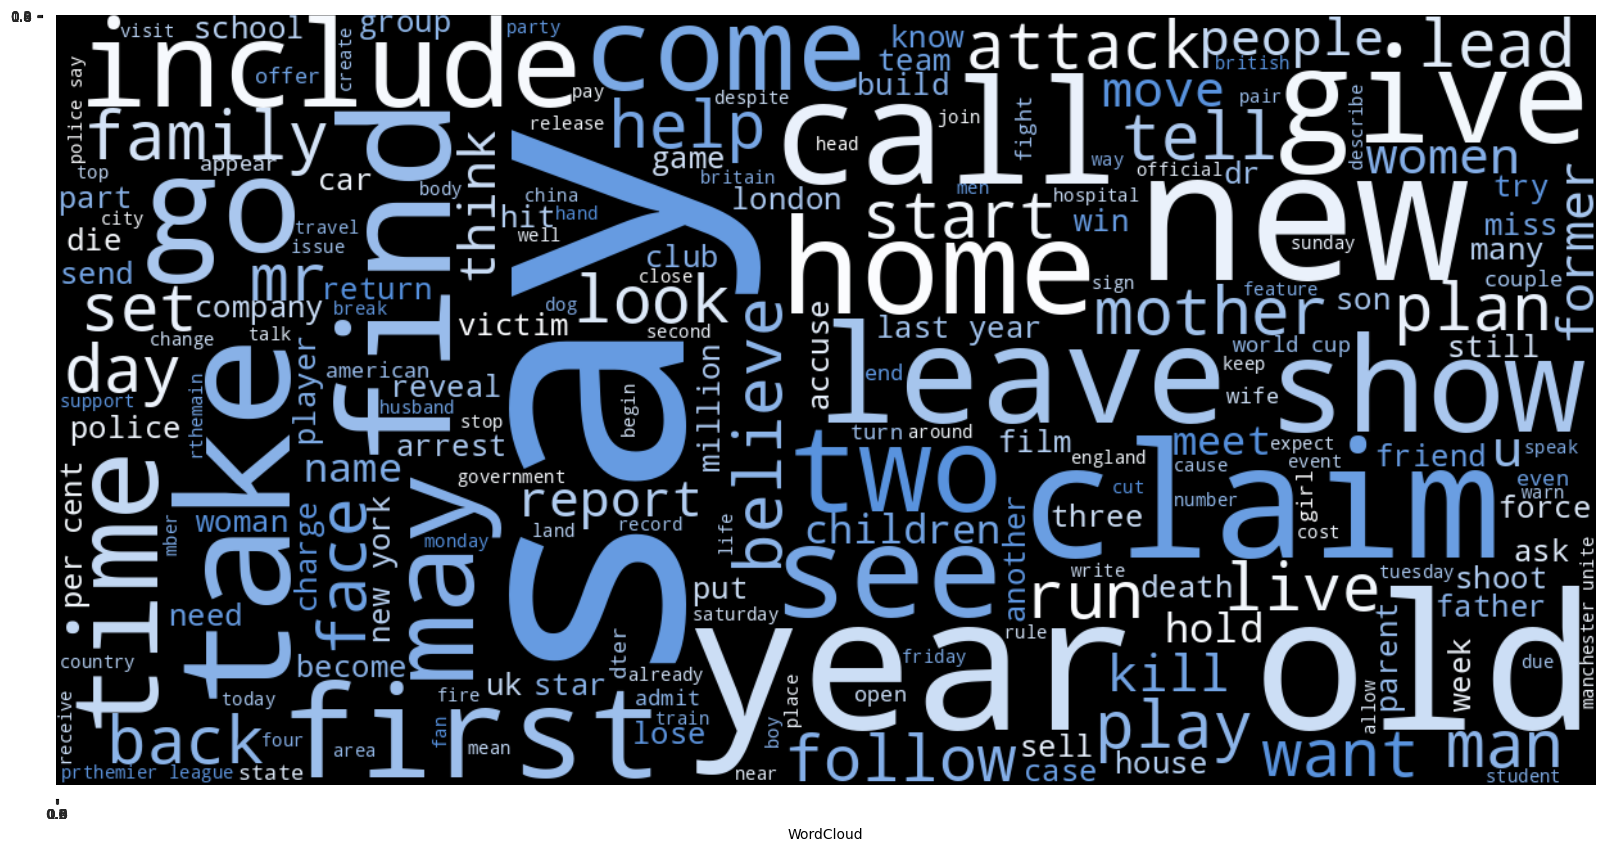

In [12]:
plot_wordcloud(' '.join(df.headlines.values.tolist()), wc_blue_color_func)

In [13]:
#plot_wordcloud(' '.join(df.text.values.tolist()), wc_blue_color_func)

Using a `start` and `end` tokens in `headlines(summary)` to let the learning algorithm know from where the headlines start's and end's.

In [14]:
df.headlines = df.headlines.apply(lambda x: f'_START_ {x} _END_')

Again adding `tokens` ... but different ones.

In [15]:
start_token = 'sostok'
end_token = 'eostok'
df.headlines = df.headlines.apply(lambda x: f'{start_token} {x} {end_token}')

It's important to use `sostok` and `eostok` as start and end tokens respectively as later while using `tensorflow's Tokenizer` will filter the tokens and covert them to lowercase.

**sostok** & **eostok** tokens are for us to know where to start & stop the summary because using `_START_` & `_END_`, tf's tokenizer with convert them to **start** & **end** respectively.

So while decoding the summary sequences of sentences like **'everything is going to end in 2012'** if use `_START_` & `_END_` tokens (which will make the sentence like **'start everything is going to end in 2012 end'** this) whome tf's tokenizer will convert to start and end then we will stop decoding as we hit first **end**, so this is bad and therefore **sostok** & **eostok** these tokens are used.

So we can just use these **sostok** & **eostok** instead of `_START_` & `_END_`, well you can but I tried both ways and while not using these `_START_` & `_END_` I was getting `undesired results` 🤯 😅 i.e. model's `results weren't good`.

In [16]:
df.sample(5)

,Unnamed: 0,text,headlines
25066,25066,daredevil sailor name write record book karate...,sostok _START_ ernie torres leap ft arizona co...
267384,267384,jose callejon first half strike help ease pres...,sostok _START_ riccardo bigon throw back behin...
276399,276399,pretoria south africa cnn talk bloodcurdling s...,sostok _START_ first day trial end defense law...
209659,209659,bianca london beat twerking crown word year ed...,sostok _START_ women spend hours take delete e...
67901,67901,bbc boss spend week long stay luxury los angel...,sostok _START_ director television bbc control...


Finding what should be the `maximum length` of text and headlines that will be feed or accepted by the learning algorithm.

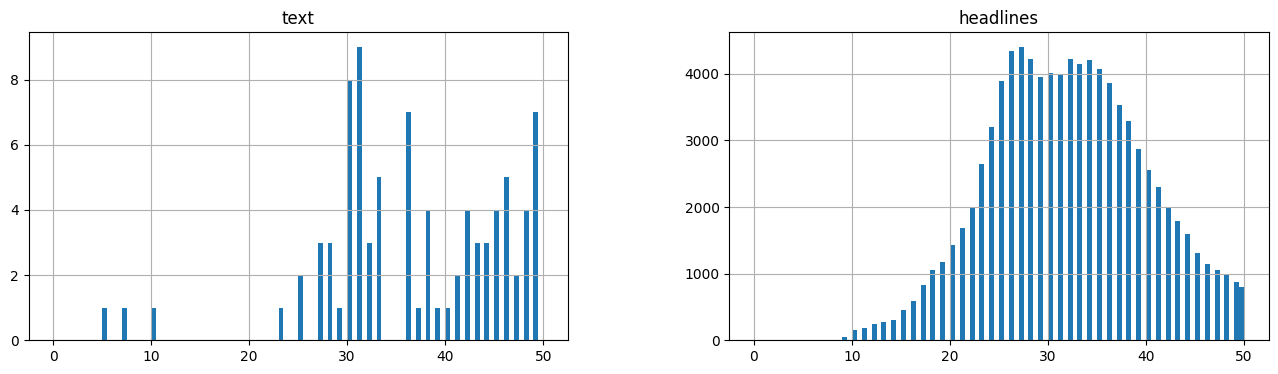

In [17]:
text_count = [len(sentence.split()) for sentence in df.text]
headlines_count = [len(sentence.split()) for sentence in df.headlines]

pd.DataFrame({'text': text_count, 'headlines': headlines_count}).hist(bins=100, figsize=(16, 4), range=[0, 50])
plt.show()

In [18]:
# To check how many rows in a column has length (of the text) <= limit
def get_word_percent(column, limit):
    count = 0
    for sentence in column:
        if len(sentence.split()) <= limit:
            count += 1

    return round(count / len(column), 2)


# Check how many % of headlines have 0-13 words
print(get_word_percent(df.headlines, 13))

# Check how many % of summary have 0-42 words
print(get_word_percent(df.text, 42))

0.01
0.0


If the length of headlines or the text is kept large the deep learning model will face issues with performance and also training will slower.

One solution for creating summary for long sentences can be break a paragraph into sentences and then create a summary for them, this way the summary will make sence instead of giving random piece of text and creating summary for it.

In [19]:
def calculate_word_count(text):
    words = text.split()
    return len(words)

df['word_count'] = df['text'].apply(calculate_word_count)

max_text_len = int(np.percentile(df['word_count'], 95))
max_text_len

739

In [20]:
def calculate_word_count(text):
    words = text.split()
    return len(words)

df['word_count'] = df['headlines'].apply(calculate_word_count)

max_summary_len = int(np.percentile(df['word_count'], 95))
max_summary_len

56

In [21]:
# select the summary and text between their defined max lens respectively
def trim_text_and_summary(df, max_text_len, max_summary_len):
    cleaned_text = np.array(df['text'])
    cleaned_summary = np.array(df['headlines'])

    short_text = []
    short_summary = []

    for i in range(len(cleaned_text)):
        if len(cleaned_text[i].split()) <= max_text_len and len(
            cleaned_summary[i].split()
        ) <= max_summary_len:
            short_text.append(cleaned_text[i])
            short_summary.append(cleaned_summary[i])

    df = pd.DataFrame({'text': short_text, 'summary': short_summary})
    return df


df = trim_text_and_summary(df, max_text_len, max_summary_len)
print(f'Dataset size: {len(df)}')
df.sample(5)

Dataset size: 90977


,text,summary
23111,damien gayle death toll nigeria islamist insur...,sostok _START_ militants storm three villages ...
8661,robinson publish est thember update est thembe...,sostok _START_ sonia cadman andrew mattle get ...
38910,lydia warren publish est thember update est th...,sostok _START_ joshua sharyn hakken kidnap son...
65905,cnn football world govern body fifa provisiona...,sostok _START_ fifa provisionally ban executiv...
62334,ted thornhill update est uary two young men fi...,sostok _START_ post mortthem result show teena...


In [22]:
# rare word analysis
def get_rare_word_percent(tokenizer, threshold):
    # threshold: if the word's occurrence is less than this then it's rare word

    count = 0
    total_count = 0
    frequency = 0
    total_frequency = 0

    for key, value in tokenizer.word_counts.items():
        total_count += 1
        total_frequency += value
        if value < threshold:
            count += 1
            frequency += value

    return {
        'percent': round((count / total_count) * 100, 2),
        'total_coverage': round(frequency / total_frequency * 100, 2),
        'count': count,
        'total_count': total_count
    }

In [23]:
# Splitting the training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    np.array(df['text']),
    np.array(df['summary']),
    test_size=0.1,
    random_state=1,
    shuffle=True
)

**Tokenizing text 👉 x**

In [24]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

x_tokens_data = get_rare_word_percent(x_tokenizer, 4)
print(x_tokens_data)

{'percent': 57.47, 'total_coverage': 0.65, 'count': 122981, 'total_count': 214006}


🔥 to `increase computation speed` use this

```python
x_tokenizer = Tokenizer(num_words=x_tokens_data['total_count'] - x_tokens_data['count'])
```

In [25]:
# else use this
#x_tokenizer = Tokenizer()
#x_tokenizer.fit_on_texts(list(x_train))

In [26]:
# save tokenizer
with open('x_tokenizer', 'wb') as f:
    pickle.dump(x_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# import tensorflow as tf
# pad_sequences(x_train_sequence[:2], padding='post', maxlen=int(max_text_len), truncating='post',value=0)

In [28]:
type(max_text_len)

int

In [29]:
# one-hot-encoding
x_train_sequence = x_tokenizer.texts_to_sequences(x_train)
x_val_sequence = x_tokenizer.texts_to_sequences(x_val)

# padding upto max_text_len
x_train_padded = pad_sequences(x_train_sequence, padding='post', maxlen=max_text_len, truncating='post', dtype='int32')
x_val_padded = pad_sequences(x_val_sequence, padding='post', maxlen=max_text_len, truncating='post', dtype='int32')

# if you're not using num_words parameter in Tokenizer then use this
x_vocab_size = len(x_tokenizer.word_index) + 1

# else use this
# x_vocab_size = x_tokenizer.num_words + 1

print(x_vocab_size)

214007


**Tokenizing headlines(summary) 👉 y**

In [30]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

y_tokens_data = get_rare_word_percent(y_tokenizer, 6)
print(y_tokens_data)

{'percent': 72.06, 'total_coverage': 3.54, 'count': 52968, 'total_count': 73504}


🔥 to `increase computation speed` use this

```python
y_tokenizer = Tokenizer(num_words=y_tokens_data['total_count'] - y_tokens_data['count'])
```

In [31]:
# else use this
#y_tokenizer = Tokenizer()
#y_tokenizer.fit_on_texts(list(y_train))

In [32]:
# save tokenizer
with open('y_tokenizer', 'wb') as f:
    pickle.dump(y_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [33]:
# one-hot-encoding
y_train_sequence = y_tokenizer.texts_to_sequences(y_train)
y_val_sequence = y_tokenizer.texts_to_sequences(y_val)

# padding upto max_summary_len
y_train_padded = pad_sequences(y_train_sequence, maxlen=max_summary_len, padding='post')
y_val_padded = pad_sequences(y_val_sequence, maxlen=max_summary_len, padding='post')

# if you're not using num_words parameter in Tokenizer then use this
y_vocab_size = len(y_tokenizer.word_index) + 1

# else use this
# y_vocab_size = y_tokenizer.num_words + 1

print(y_vocab_size)

73505


In [34]:
# removing summary which only has sostok & eostok
def remove_indexes(summary_array):
    remove_indexes = []
    for i in range(len(summary_array)):
        count = 0
        for j in summary_array[i]:
            if j != 0:
                count += 1
        if count == 2:
            remove_indexes.append(i)
    return remove_indexes


remove_train_indexes = remove_indexes(y_train_padded)
remove_val_indexes = remove_indexes(y_val_padded)

y_train_padded = np.delete(y_train_padded, remove_train_indexes, axis=0)
x_train_padded = np.delete(x_train_padded, remove_train_indexes, axis=0)

y_val_padded = np.delete(y_val_padded, remove_val_indexes, axis=0)
x_val_padded = np.delete(x_val_padded, remove_val_indexes, axis=0)

In [35]:
latent_dim = 512
embedding_dim = 300
num_epochs = 50

In [36]:
def get_embedding_matrix(tokenizer, embedding_dim, vocab_size=None):
    word_index = tokenizer.word_index
    voc = list(word_index.keys())

    path_to_glove_file = '/home/mainaksen/Ankan/Text/archive/glove.6B.300d.txt'

    embeddings_index = {}
    with open(path_to_glove_file) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    print("Found %s word vectors." % len(embeddings_index))

    num_tokens = len(voc) + 2 if not vocab_size else vocab_size
    hits = 0
    misses = 0

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

    return embedding_matrix


x_embedding_matrix = get_embedding_matrix(x_tokenizer, embedding_dim, x_vocab_size)
y_embedding_matrix = get_embedding_matrix(y_tokenizer, embedding_dim, y_vocab_size)

Found 400000 word vectors.
Converted 126742 words (87264 misses)
Found 400000 word vectors.
Converted 58217 words (15287 misses)


In [37]:
print(x_embedding_matrix.shape)
print(y_embedding_matrix.shape)

(214007, 300)
(73505, 300)


Using `pre-trained` embeddings and keeping the `Embedding` layer `non-trainable` we get increase in computation speed as don't need to compute the embedding matrix.

**Here there 3 different training models**
- `build_seq2seq_model_with_just_lstm` - **Seq2Seq model with just LSTMs**. Both `encoder` and `decoder` have just `LSTM`s.
- `build_seq2seq_model_with_bidirectional_lstm` - **Seq2Seq model with Bidirectional LSTMs**. Both `encoder` and `decoder` have `Bidirectional LSTM`s.
- `build_hybrid_seq2seq_model` - **Seq2Seq model with hybrid architecture**. Here `encoder` has `Bidirectional LSTM`s while `decoder` has just `LSTM`s.

**Inference methods for the 3 different learning models - just add `_inference` as `prefix`**
- `build_seq2seq_model_with_just_lstm_inference`
- `build_seq2seq_model_with_bidirectional_lstm_inference`
- `build_hybrid_seq2seq_model_inference`

**Decoding sequence for the 3 different learning models - just add `decode_sequence_` as `suffix`**
- `decode_sequence_build_seq2seq_model_with_just_lstm`
- `decode_sequence_build_seq2seq_model_with_bidirectional_lstm`
- `decode_sequence_build_hybrid_seq2seq_model`

**Seq2Seq model with just LSTMs**. Both `encoder` and `decoder` have just `LSTM`s.

In [38]:
def build_seq2seq_model_with_just_lstm(
    embedding_dim, latent_dim, max_text_len, 
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
):
    # instantiating the model in the strategy scope creates the model on the TPU
   # with tpu_strategy.scope():

    # =====================
    # 🔥 Encoder
    # =====================
    encoder_input = Input(shape=(max_text_len, ))

    # encoder embedding layer
    encoder_embedding = Embedding(
        x_vocab_size,
        embedding_dim,
        embeddings_initializer=tf.keras.initializers.Constant(x_embedding_matrix),
        trainable=False
    )(encoder_input)

    # encoder lstm 1
    encoder_lstm1 = LSTM(
        latent_dim,
        return_sequences=True,
        return_state=True,
        dropout=0.4,
        recurrent_dropout=0.4
    )
    encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_embedding)

    # encoder lstm 2
    encoder_lstm2 = LSTM(
        latent_dim,
        return_sequences=True,
        return_state=True,
        dropout=0.4,
        recurrent_dropout=0.4
    )
    encoder_output, *encoder_final_states = encoder_lstm2(encoder_output1)

    # =====================
    # 🌈 Decoder
    # =====================

    # Set up the decoder, using `encoder_states` as initial state.

    decoder_input = Input(shape=(None, ))

    # decoder embedding layer
    decoder_embedding_layer = Embedding(
        y_vocab_size,
        embedding_dim,
        embeddings_initializer=tf.keras.initializers.Constant(y_embedding_matrix),
        trainable=True
    )
    decoder_embedding = decoder_embedding_layer(decoder_input)

    # decoder lstm 1
    decoder_lstm = LSTM(
        latent_dim,
        return_sequences=True,
        return_state=True,
        dropout=0.4,
        recurrent_dropout=0.4
    )
    decoder_output, *decoder_final_states = decoder_lstm(
        decoder_embedding, initial_state=encoder_final_states
    )

    # dense layer
    decoder_dense = TimeDistributed(
        Dense(y_vocab_size, activation='softmax')
    )
    decoder_output = decoder_dense(decoder_output)

    # =====================
    # ⚡️ Model
    # =====================
    model = Model([encoder_input, decoder_input], decoder_output)
    model.summary()

    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return {
        'model': model,
        'inputs': {
            'encoder': encoder_input,
            'decoder': decoder_input
        },
        'outputs': {
            'encoder': encoder_output,
            'decoder': decoder_output
        },
        'states': {
            'encoder': encoder_final_states,
            'decoder': decoder_final_states
        },
        'layers': {
            'decoder': {
                'embedding': decoder_embedding_layer,
                'last_decoder_lstm': decoder_lstm,
                'dense': decoder_dense
            }
        }
    }

**Seq2Seq model with Bidirectional LSTMs**. Both `encoder` and `decoder` have `Bidirectional LSTM`s.

In [39]:
def build_seq2seq_model_with_bidirectional_lstm(
    embedding_dim, latent_dim, max_text_len, 
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
):
    # instantiating the model in the strategy scope creates the model on the TPU
    #with tpu_strategy.scope():

    # =====================
    # 🔥 Encoder
    # =====================
    encoder_input = Input(shape=(max_text_len, ))

    # encoder embedding layer
    encoder_embedding = Embedding(
        x_vocab_size,
        embedding_dim,
        embeddings_initializer=tf.keras.initializers.Constant(x_embedding_matrix),
        trainable=False,
        name='encoder_embedding'
    )(encoder_input)

    # encoder lstm1
    encoder_bi_lstm1 = Bidirectional(
        LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4,
            name='encoder_lstm_1'
        ),
        name='encoder_bidirectional_lstm_1'
    )
    encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_bi_lstm1(
        encoder_embedding
    )
    encoder_bi_lstm1_output = [
        encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1
    ]

    # encoder lstm 2
    encoder_bi_lstm2 = Bidirectional(
        LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4,
            name='encoder_lstm_2'
        ),
        name='encoder_bidirectional_lstm_2'
    )
    encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_bi_lstm2(
        encoder_output1
    )
    encoder_bi_lstm2_output = [
        encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2
    ]

    # encoder lstm 3
    encoder_bi_lstm = Bidirectional(
        LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4,
            name='encoder_lstm_3'
        ),
        name='encoder_bidirectional_lstm_3'
    )
    encoder_output, *encoder_final_states = encoder_bi_lstm(encoder_output2)

    # =====================
    # 🌈 Decoder
    # =====================

    # Set up the decoder, using `encoder_states` as initial state.

    decoder_input = Input(shape=(None, ))

    # decoder embedding layer
    decoder_embedding_layer = Embedding(
        y_vocab_size,
        embedding_dim,
        embeddings_initializer=tf.keras.initializers.Constant(y_embedding_matrix),
        trainable=False,
        name='decoder_embedding'
    )
    decoder_embedding = decoder_embedding_layer(decoder_input)

    decoder_bi_lstm = Bidirectional(
        LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.2,
            name='decoder_lstm_1'
        ),
        name='decoder_bidirectional_lstm_1'
    )
    decoder_output, *decoder_final_states = decoder_bi_lstm(
        decoder_embedding, initial_state=encoder_final_states
        # decoder_embedding, initial_state=encoder_final_states[:2]
    )  # taking only the forward states

    # dense layer
    decoder_dense = TimeDistributed(
        Dense(y_vocab_size, activation='softmax')
    )
    decoder_output = decoder_dense(decoder_output)

    # =====================
    # ⚡️ Model
    # =====================
    model = Model([encoder_input, decoder_input], decoder_output, name='seq2seq_model_with_bidirectional_lstm')
    model.summary()

    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return {
        'model': model,
        'inputs': {
            'encoder': encoder_input,
            'decoder': decoder_input
        },
        'outputs': {
            'encoder': encoder_output,
            'decoder': decoder_output
        },
        'states': {
            'encoder': encoder_final_states,
            'decoder': decoder_final_states
        },
        'layers': {
            'decoder': {
                'embedding': decoder_embedding_layer,
                'last_decoder_lstm': decoder_bi_lstm,
                'dense': decoder_dense
            }
        }
    }

**Seq2Seq model with hybrid architecture**. Here `encoder` has `Bidirectional LSTM`s while `decoder` has just `LSTM`s.

In [40]:
def build_hybrid_seq2seq_model(
    embedding_dim, latent_dim, max_text_len, 
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
):
    # instantiating the model in the strategy scope creates the model on the TPU
    #with tpu_strategy.scope():

    # =====================
    # 🔥 Encoder
    # =====================
    encoder_input = Input(shape=(max_text_len, ))

    # encoder embedding layer
    encoder_embedding = Embedding(
        x_vocab_size,
        embedding_dim,
        embeddings_initializer=tf.keras.initializers.Constant(x_embedding_matrix),
        trainable=False,
        name='encoder_embedding'
    )(encoder_input)

    # encoder lstm1
    encoder_bi_lstm1 = Bidirectional(
        LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4,
            name='encoder_lstm_1'
        ),
        name='encoder_bidirectional_lstm_1'
    )
    encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_bi_lstm1(
        encoder_embedding
    )
    encoder_bi_lstm1_output = [
        encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1
    ]

    # encoder lstm 2
    encoder_bi_lstm2 = Bidirectional(
        LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4,
            name='encoder_lstm_2'
        ),
        name='encoder_bidirectional_lstm_2'
    )
    encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_bi_lstm2(
        encoder_output1
    )
    encoder_bi_lstm2_output = [
        encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2
    ]

    # encoder lstm 3
    encoder_bi_lstm = Bidirectional(
        LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4,
            name='encoder_lstm_3'
        ),
        name='encoder_bidirectional_lstm_3'
    )
    encoder_output, *encoder_final_states = encoder_bi_lstm(encoder_output2)

    # =====================
    # 🌈 Decoder
    # =====================

    # Set up the decoder, using `encoder_states` as initial state.

    decoder_input = Input(shape=(None, ))

    # decoder embedding layer
    decoder_embedding_layer = Embedding(
        y_vocab_size,
        embedding_dim,
        embeddings_initializer=tf.keras.initializers.Constant(y_embedding_matrix),
        trainable=False,
        name='decoder_embedding'
    )
    decoder_embedding = decoder_embedding_layer(decoder_input)

    decoder_lstm = LSTM(
        latent_dim,
        return_sequences=True,
        return_state=True,
        dropout=0.4,
        recurrent_dropout=0.2,
        name='decoder_lstm_1'
    )
    decoder_output, *decoder_final_states = decoder_lstm(
        decoder_embedding, initial_state=encoder_final_states[:2]
    )  # taking only the forward states

    # dense layer
    decoder_dense = TimeDistributed(
        Dense(y_vocab_size, activation='softmax')
    )
    decoder_output = decoder_dense(decoder_output)

    # =====================
    # ⚡️ Model
    # =====================
    model = Model([encoder_input, decoder_input], decoder_output, name='seq2seq_model_with_bidirectional_lstm')
    model.summary()

    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return {
        'model': model,
        'inputs': {
            'encoder': encoder_input,
            'decoder': decoder_input
        },
        'outputs': {
            'encoder': encoder_output,
            'decoder': decoder_output
        },
        'states': {
            'encoder': encoder_final_states,
            'decoder': decoder_final_states
        },
        'layers': {
            'decoder': {
                'embedding': decoder_embedding_layer,
                'last_decoder_lstm': decoder_lstm,
                'dense': decoder_dense
            }
        }
    }

In [41]:
seq2seq = build_seq2seq_model_with_just_lstm(
    embedding_dim, latent_dim, max_text_len, 
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
)

2023-08-18 03:00:16.382443: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-08-18 03:00:16.397061: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-08-18 03:00:16.436817: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-08-18 03:00:16.438607: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:d8:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-08-18 03:00:16.438644: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 739)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 739, 300)     64202100    input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 739, 512), ( 1665024     embedding[0][0]                  
______________________________________________________________________________________________

If you want to change `model` then just change the `function name` above.

In [42]:
model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

In [43]:
model.layers[-2].input

[<KerasTensor: shape=(None, None, 300) dtype=float32 (created by layer 'embedding_1')>,
 <KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'lstm_1')>,
 <KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'lstm_1')>]

In [44]:
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.000001, verbose=1),
]

Use a `tuple` instead of `list` in `validation_parameter` in `model.fit()`, to know the reason reading this [post](https://stackoverflow.com/questions/61586981/valueerror-layer-sequential-20-expects-1-inputs-but-it-received-2-input-tensor).

In [45]:
history = model.fit(
    [x_train_padded, y_train_padded[:, :-1]],
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs=num_epochs,
    batch_size=512, #* tpu_strategy.num_replicas_in_sync,
    callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]],
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )
)

2023-08-18 03:00:56.081314: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-08-18 03:00:56.081910: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2100000000 Hz


Epoch 1/50
160/160 [==============================] - 11611s 72s/step - loss: 5.5620 - accuracy: 0.4412 - val_loss: 4.1193 - val_accuracy: 0.5027
Epoch 2/50
160/160 [==============================] - 11685s 73s/step - loss: 4.1861 - accuracy: 0.4934 - val_loss: 3.8848 - val_accuracy: 0.5112
Epoch 3/50
160/160 [==============================] - 11731s 73s/step - loss: 3.9681 - accuracy: 0.5004 - val_loss: 3.7792 - val_accuracy: 0.5157
Epoch 4/50
160/160 [==============================] - 11785s 74s/step - loss: 3.8362 - accuracy: 0.5059 - val_loss: 3.7076 - val_accuracy: 0.5197
Epoch 5/50
160/160 [==============================] - 11652s 73s/step - loss: 3.7526 - accuracy: 0.5088 - val_loss: 3.6585 - val_accuracy: 0.5231
Epoch 6/50
160/160 [==============================] - 11258s 70s/step - loss: 3.6709 - accuracy: 0.5125 - val_loss: 3.6274 - val_accuracy: 0.5247
Epoch 7/50
160/160 [==============================] - 11306s 71s/step - loss: 3.6102 - accuracy: 0.5151 - val_loss: 3.6035 -

**Plotting model's performance**

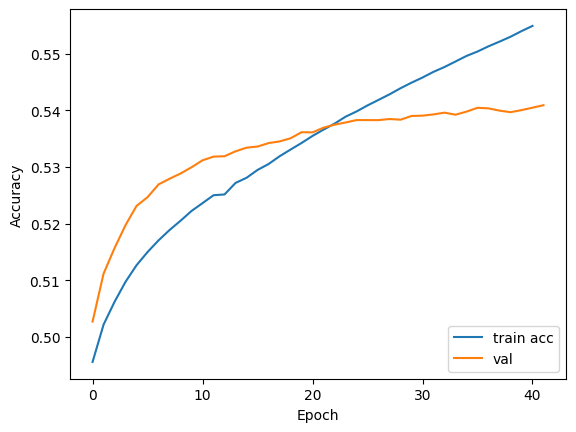

In [46]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

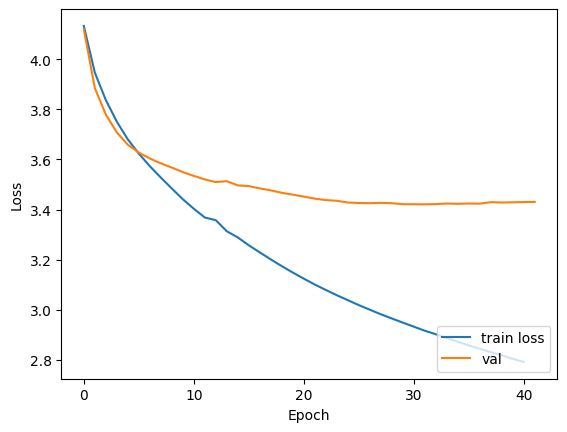

In [47]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [48]:
# Next, let’s build the dictionary to convert the index to word for target and source vocabulary:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [49]:
def build_seq2seq_model_with_just_lstm_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
):
    # Encode the input sequence to get the feature vector
    encoder_model = Model(
        inputs=encoder_input, outputs=[encoder_output] + encoder_final_states
    )

    # Decoder setup
    # Below tensors will hold the states of the previous time step
    decoder_state_input_h = Input(shape=(latent_dim, ))
    decoder_state_input_c = Input(shape=(latent_dim, ))
    decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

    # Get the embeddings of the decoder sequence
    decoder_embedding = decoder_embedding_layer(decoder_input)

    # To predict the next word in the sequence, set the initial
    # states to the states from the previous time step
    decoder_output, *decoder_states = last_decoder_lstm(
        decoder_embedding,
        initial_state=[decoder_state_input_h, decoder_state_input_c]
    )

    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_output = decoder_dense(decoder_output)

    # Final decoder model
    decoder_model = Model(
        [decoder_input] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c], 
        [decoder_output] + decoder_states
    )

    return (encoder_model, decoder_model)

Useful `stackoverflow` [post](https://stackoverflow.com/questions/60697843/tensorflow-keras-bidirectional-lstm-for-text-summarization) to understand `inference` process when using `bidirectional lstms` in `encoder` and `decoder` in the training model.

In [50]:
def build_seq2seq_model_with_bidirectional_lstm_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_bi_lstm
):

    # Encode the input sequence to get the feature vector
    encoder_model = Model(
        inputs=encoder_input, outputs=[encoder_output] + encoder_final_states
    )

    # Decoder setup
    # Below tensors will hold the states of the previous time step
    decoder_state_forward_input_h = Input(shape=(latent_dim, ))
    decoder_state_forward_input_c = Input(shape=(latent_dim, ))
    decoder_state_backward_input_h = Input(shape=(latent_dim, ))
    decoder_state_backward_input_c = Input(shape=(latent_dim, ))

    # Create the hidden input layer with twice the latent dimension,
    # since we are using bi - directional LSTM's we will get 
    # two hidden states and two cell states
    decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim * 2))

    decoder_initial_state = [
        decoder_state_forward_input_h, decoder_state_forward_input_c,
        decoder_state_backward_input_h, decoder_state_backward_input_c
    ]

    # Get the embeddings of the decoder sequence
    decoder_embedding = decoder_embedding_layer(decoder_input)

    # To predict the next word in the sequence, set the initial
    # states to the states from the previous time step
    decoder_output, *decoder_states = last_decoder_bi_lstm(
        decoder_embedding, initial_state=decoder_initial_state
    )

    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_output = decoder_dense(decoder_output)

    # Final decoder model
    decoder_model = Model(
        [decoder_input] + [decoder_hidden_state_input] + decoder_initial_state,
        [decoder_output] + decoder_states
    )

    return (encoder_model, decoder_model)

In [51]:
def build_hybrid_seq2seq_model_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_bi_lstm
):

    # Encode the input sequence to get the feature vector
    encoder_model = Model(
        inputs=encoder_input, outputs=[encoder_output] + encoder_final_states
    )

    # Decoder setup
    # Below tensors will hold the states of the previous time step
    decoder_state_forward_input_h = Input(shape=(latent_dim, ))
    decoder_state_forward_input_c = Input(shape=(latent_dim, ))
    # decoder_state_backward_input_h = Input(shape=(latent_dim, ))
    # decoder_state_backward_input_c = Input(shape=(latent_dim, ))

    # Create the hidden input layer with twice the latent dimension,
    # since we are using bi - directional LSTM's we will get 
    # two hidden states and two cell states
    decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim * 2))

    decoder_initial_state = [
        decoder_state_forward_input_h, decoder_state_forward_input_c,
        #decoder_state_backward_input_h, decoder_state_backward_input_c
    ]

    # Get the embeddings of the decoder sequence
    decoder_embedding = decoder_embedding_layer(decoder_input)

    # To predict the next word in the sequence, set the initial
    # states to the states from the previous time step
    decoder_output, *decoder_states = last_decoder_bi_lstm(
        decoder_embedding, initial_state=decoder_initial_state
    )

    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_output = decoder_dense(decoder_output)

    # Final decoder model
    decoder_model = Model(
        [decoder_input] + [decoder_hidden_state_input] + decoder_initial_state,
        [decoder_output] + decoder_states
    )

    return (encoder_model, decoder_model)

In [52]:
encoder_model, decoder_model = build_seq2seq_model_with_just_lstm_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
)

In [53]:
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 739)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 739, 300)          64202100  
_________________________________________________________________
lstm (LSTM)                  [(None, 739, 512), (None, 1665024   
_________________________________________________________________
lstm_1 (LSTM)                [(None, 739, 512), (None, 2099200   
Total params: 67,966,324
Trainable params: 3,764,224
Non-trainable params: 64,202,100
_________________________________________________________________


In [54]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 300)    22051500    input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 512)]        0                                            
____________________________________________________________________________________________

In [55]:
decoder_model.layers[-3].input

[<KerasTensor: shape=(None, None, 300) dtype=float32 (created by layer 'embedding_1')>,
 <KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'lstm_1')>,
 <KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'lstm_1')>]

Converting from `sequence to text` for model `with just LSTM's` and for model `with Bidirectional LSTM's`.

In [56]:
def decode_sequence_seq2seq_model_with_just_lstm(
    input_sequence, encoder_model, decoder_model
):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_sequence)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index[start_token]

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + [e_out, e_h, e_c]
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != end_token:
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == end_token) or (len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [57]:
def decode_sequence_seq2seq_model_with_bidirectional_lstm(
    input_sequence, encoder_model, decoder_model
):
    # Encode the input as state vectors.
    e_out, *state_values = encoder_model.predict(input_sequence)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index[start_token]

    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, *decoder_states = decoder_model.predict(
            [target_seq] + [e_out] + state_values
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :]) # Greedy Search
        sampled_token = reverse_target_word_index[sampled_token_index + 1]
        
        if sampled_token != end_token:
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == end_token) or (len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        state_values = decoder_states

    return decoded_sentence

In [58]:
def decode_sequence_hybrid_seq2seq_model(
    input_sequence, encoder_model, decoder_model
):
    # Encode the input as state vectors.
    e_out, *state_values = encoder_model.predict(input_sequence)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index[start_token]

    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, *decoder_states = decoder_model.predict(
            [target_seq] + [e_out] + state_values[:2]
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :]) # Greedy Search
        sampled_token = reverse_target_word_index[sampled_token_index + 1]
        
        if sampled_token != end_token:
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == end_token) or (len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        state_values = decoder_states

    return decoded_sentence

In [59]:
def seq2summary(input_sequence):
    new_string = ''
    for i in input_sequence:
        if (
            (i != 0 and i != target_word_index[start_token]) and
            (i != target_word_index[end_token])
        ):
            new_string = new_string + reverse_target_word_index[i] + ' '
    return new_string

In [60]:
def seq2text(input_sequence):
    new_string = ''
    for i in input_sequence:
        if i != 0:
            new_string = new_string + reverse_source_word_index[i] + ' '
    return new_string

In [61]:
l = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

if len(l) % 3 != 0:
    while len(l) % 3 != 0:
        l.append(0)
print(l)

lst_i = 3
for i in range(0, len(l), 3):
    print(l[i:i + lst_i])

print(' '.join(['', 'james', 'ethan', '', 'tony']))
print(' '.join(' '.join(['', 'james', 'ethan', '', 'tony']).split()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0, 0]
[1, 2, 3]
[4, 5, 6]
[7, 8, 9]
[10, 0, 0]
 james ethan  tony
james ethan tony


For predicting `unseen` data pass `decode_sequence` function for which you want to decode.

In [62]:
def predict_text(text, decode_sequence, encoder_model, decoder_model):
    original_text = text
    text = clean_text([text])  # generator
    text_list = original_text.split()

    if len(text_list) <= max_text_len:
        text = expand_contractions(text)
        text = clean_text(text)
        text = f'_START_ {text} _END_'
        text = f'{start_token} {text} {end_token}'

        seq = x_tokenizer.texts_to_sequences([' '.join(text_list)])
        padded = pad_sequences(seq, maxlen=max_text_len, padding='post')
        pred_summary = decode_sequence(
            padded.reshape(1, max_text_len), encoder_model, decoder_model
        )
        return pred_summary
    else:
        pred_summary = ''

        # breaking long texts to individual max_text_len texts and predicting on them
        while len(text_list) % max_text_len == 0:
            text_list.append('')

        lst_i = max_text_len
        for i in range(0, len(text_list), max_text_len):
            _text_list = original_text.split()[i:i + lst_i]
            _text = ' '.join(_text_list)
            _text = ' '.join(
                _text.split()
            )  # to remove spaces that were added to make len(text_list) % max_text_len == 0

            _text = expand_contractions(_text)
            _text = clean_text(_text)  # generator
            _text = f'_START_ {_text} _END_'
            _text = f'{start_token} {_text} {end_token}'
            # print(_text, '\n')

            _seq = x_tokenizer.texts_to_sequences([_text])
            _padded = pad_sequences(_seq, maxlen=max_text_len, padding='post')
            _pred = decode_sequence(
                _padded.reshape(1, max_text_len), encoder_model, decoder_model
            )
            pred_summary += ' ' + ' '.join(_pred.split()[1:-2])
            pred_summary = ' '.join(pred_summary.split())

        return pred_summary

## 🔮 Predictions


In [63]:
# Testing on training data
for i in range(0, 15):
    print(f"# {i+1} News: ", seq2text(x_train_padded[i]))
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_seq2seq_model_with_just_lstm(
            x_train_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()

# 1 News:  mailonline reporter new jersey man spark controversy among neighbor fly flag associate jihadist group islamic state say whole thing big misunderstand dunaway garwood say fly flag fridays holy month ramadan years since long isis militants adopt symbol dunaway flag say arabic one god allah prophet muhammad messenger symbol faith every muslim use black flag dunway tell nj com find mosque world american citizen love country also muslim use flag say muslim mr dunaway fly flag outside garwood new jersey home years neighbor recently notice think dunaway support isis jihadists kashmiri dthemonstrators hold flag islamic state dthemonstration israeli military operations gaza although group adopt flag long symbol islam historically associate terrorist group controversy begin tuesday investment manager leibowitz tweet photo flag comment scary jihadists garwood write one commenter photo think right time fly type flag local resident jam mchugh tell news especially go time neighbor diana f

Predicted summary:   start mexican authorities arrest suspect mexican border mexican border patrol agent say arrest warrant issue man arrest warrant issue end

# 5 News:  john hall secret underground bunker build protect essential service event nuclear war go hammer bunker construct coswarth cornwall height cold war build experts south west water authority would able maintain water sewerage operations nuclear themergency square foot bunker build house people seven operations room six communications room three control room guide price cold war bunker build design experts south west water authority would able maintain water sewerage operations nuclear themergency discrete room deep underground hint life surface small brick entrance build bunker feature include several blast proof doors air lock ntamination room din room recreation room two dormitories room deep underground hint life surface small brick entrance build brian blake south west water asset performance manager work authority t

Predicted summary:   start england face australia second test series sri lanka defeat sri lanka defeat sri lanka defeat sri lanka defeat sri lanka defeat sri lanka end

# 9 News:  cnn residents portion new mexico texas deal thursday rare winter storm foot snow fall south allo texas panhandle national weather service say allo record th snowiest day record date back el paso texas las cruces new mexico accustom wintry dust see usual share white stuff thursday snow continue fall eastern new mexico el paso several road closure school closure announce texas department transportation warn motorists stay roads watch black ice roadways el paso area new mexico state police tweet several road closure crash due whiteout condition notably interstate westbound close las cruces inch snow record midday foot snow fell east raton new mexico town folsom say national weather service new mexico resident danielle rodeheaver post photos twitter say tell move las cruces rare snow snow day white sand missile r

Predicted summary:   start new york city hall say new york city hall hall fame hall fame hall fame hall fame hall fame hall fame hall fame hall fame hall fame hall fame hall fame hall fame hall fame end

# 14 News:  ashley collman associate press publish est update est woman arrest attthempt smuggle three pound cocaine tuesday customs border protection officials apprehend year old phoenix arizona resident dora anna gutierrez morley pedestrian gate strap rear end find three pound cocaine value dollars drug mule phoenix arizona woman catch try smuggle worth cocaine tap underwear morley pedestrian gate gutierrez stop part larger arizona mexico border one busiest border spot country arizona border process million pedestrians half drug seize illegal immigrants apprehend enter seize apprehend arizona accord customs border control website response increase organize crime border region alliance combat transnational threats actt start collaboration federal state local tribal agencies arizona me

In [64]:
# Testing on validation data
for i in range(0, 15):
    print(f"# {i+1} News: ", seq2text(x_val_padded[i]))
    print("Original summary: ", seq2summary(y_val_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_seq2seq_model_with_just_lstm(
            x_val_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()

# 1 News:  caroline flack holiday ibiza word finally arrive keep hang year itv boss de part next series factor popular spin show xtra factor promptly go get rag drink type moan difficult things prefer say things challenge certainly work simon cowell whether rag riches talent show winner highly pay judge presenter take toll caroline say therapy helpful change way think self confess worrier caroline successful host xtra factor since main show rat plummet time chthemistry co host olly murs make sure xtra factor go world wife audition role stand smile even cut job give radio dj sarah crawford simon would probably say inevitable shrug showbiz news departure break caroline twitter caroline meet flood online abuse start date harry style years three brilliant years host xtra factor time pass baton incredible never forget say today stoical cut throat nature business industry learn cope quite early prepare like say competitive industry always people want job much know industry like make fun inte

Predicted summary:   start netflix stream service netflix stream service netflix netflix stream service netflix netflix stream service netflix netflix stream service netflix netflix stream service netflix netflix netflix netflix netflix netflix netflix netflix netflix netflix netflix netflix netflix netflix netflix netflix netflix netflix netflix netflix netflix netflix netflix netflix netflix netflix netflix netflix netflix netflix netflix netflix

# 4 News:  mindy tran lock front door home lawrence massachusetts turn around saw car roll steep driveway two year old twin dters strap backseat busy road instantly spring action know either mine live teary year old tell wcvb courageous mindy tran use human speed bump car carry two dters start roll driveway busy street crush right knee dislocate leave hip dters everything mindy tran say first instinct save twin think twice throw behind car year old recently move house lawrence massachusetts incident occur car garage start roll backwards dan

Predicted summary:   start year old girl play basketball team play basketball team usa play basketball team usa end

# 8 News:  sarah michael former child actor young talent time star debra byrne come forward new claim abuse set teenager post plea witness contact facebook byrne name two allege abusers describe assault swim pool film film caravan holiday day film crew swim pool recall pool pool name withhold swim digitally rap write post since delete scroll video debra byrne leave young talent time co star include johnny young third leave byrne post plea witness allege abuse suffer set come forward facebook since delete post disturb girl abuse believe consider fair game byrne would years old time also reference another incident allege take place young talent time star johnny young film red tulip chocolates commercial two people studio jog anyone mthemory comfortable speak take place studio please contact post daily mail australia contact byrne comment debra byrne launch appeal facebook 

Predicted summary:   start new government say government plan new government plan new government plan new government plan new government plan new government plan new york city mayor say new york city mayor bloomberg say city mayor bloomberg say end

# 11 News:  steve robson publish est may update est may fthemale helicopter pilot hail hero crash land ft busy city centre without cause serious injuries hawaii link pilot light aircraft passenger karl hedburg photography trip engine suddenly cut capital honolulu helicopter plummet street land close large apartment complex hawaii pacific university around pm miraculously one seriously injure scroll video small helicopter fly hawaii capital honolulu lose power ft helicopter crash middle busy pedestrian area miraculously one seriously injure everything sethem normal aircraft miss link tell kitv sudden get real quiet engine quit first think joke like oh god real three thousand feet lot time think things practice time keep cool head miss link e

Predicted summary:   start new york city council say new york city new york city mayor bloomberg say city mayor bloomberg say city mayor bloomberg city mayor bloomberg city mayor bloomberg city mayor bloomberg city mayor bloomberg say city mayor bloomberg end

# 14 News:  voters last year parliamentary elections lodge complaints aggressive campaign voters last year parliamentary elections lodge complaints aggressive campaign tactics fight rival supporters bizarre activities poll day new data show one case voter complain wealthy party donors lure young activists key seat unfair promise free curry nightclub entertainment hotel stay others letter complaint police force local authorities accuse politicians fly post detectives call scrap break conflict political view detail release press association freedom information act refer parliamentary elections clacton heywood middleton newark rochester strood wythenshawe sale east one eagle eye viewer watch live coverage rochester strood election u

## 🎁 Saving the model

In [2]:
# HDF5 format
#tf.saved_model.save(model, export_dir="saved_models")
# model.save('model.h5')    
# encoder_model.save('encoder_model.h5')
# decoder_model.save('decoder_model.h5')
#options = tf.saved_model.SaveOptions(compression='GZIP')
model.save('model_savedmodel' , save_format='tf')
shutil.make_archive('compressed_model', 'zip','model_savedmodel')

In [ ]:
tf.saved_model.save(encoder_model, export_dir="/saved_models")
tf.saved_model.save(decoder_model, export_dir="/saved_models")

## 🏌️‍♂️ Running all the 3 different models

After understanding how all the pieces work, running all the `3 models` to understand how it `performs` and its `results`.

**Here there 3 different training models**
- `build_seq2seq_model_with_just_lstm` - **Seq2Seq model with just LSTMs**. Both `encoder` and `decoder` have just `LSTM`s.
- `build_seq2seq_model_with_bidirectional_lstm` - **Seq2Seq model with Bidirectional LSTMs**. Both `encoder` and `decoder` have `Bidirectional LSTM`s.
- `build_hybrid_seq2seq_model` - **Seq2Seq model with hybrid architecture**. Here `encoder` has `Bidirectional LSTM`s while `decoder` has just `LSTM`s.

**Inference methods for the 3 different learning models - just add `_inference` as `prefix`**
- `build_seq2seq_model_with_just_lstm_inference`
- `build_seq2seq_model_with_bidirectional_lstm_inference`
- `build_hybrid_seq2seq_model_inference`

**Decoding sequence for the 3 different learning models - just add `decode_sequence_` as `suffix`**
- `decode_sequence_build_seq2seq_model_with_just_lstm`
- `decode_sequence_build_seq2seq_model_with_bidirectional_lstm`
- `decode_sequence_build_hybrid_seq2seq_model`

In [80]:
models_info = {
    'just_lstm': {
        'model': build_seq2seq_model_with_just_lstm,
        'inference': build_seq2seq_model_with_just_lstm_inference,
        'decode_sequence': decode_sequence_seq2seq_model_with_just_lstm
    },
    'bidirectional_lstm': {
        'model': build_seq2seq_model_with_bidirectional_lstm,
        'inference': build_seq2seq_model_with_bidirectional_lstm_inference,
        'decode_sequence': decode_sequence_seq2seq_model_with_bidirectional_lstm
    },
    'hybrid_model': {
        'model': build_hybrid_seq2seq_model,
        'inference': build_hybrid_seq2seq_model_inference,
        'decode_sequence': decode_sequence_hybrid_seq2seq_model
    }
}

**Model with just LSTMs**

In [81]:
model_func = models_info['just_lstm']['model']
inference_func = models_info['just_lstm']['inference']
decode_sequence_func = models_info['just_lstm']['decode_sequence']

In [82]:
seq2seq = model_func(
    embedding_dim, latent_dim, max_text_len, 
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
)

model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 739)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 739, 300)     64202100    input_6[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 739, 512), ( 1665024     embedding_2[0][0]                
____________________________________________________________________________________________

In [3]:
history = model.fit(
    [x_train_padded, y_train_padded[:, :-1]],
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs=num_epochs,
    batch_size=128 * tpu_strategy.num_replicas_in_sync,
    callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]],
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )
)

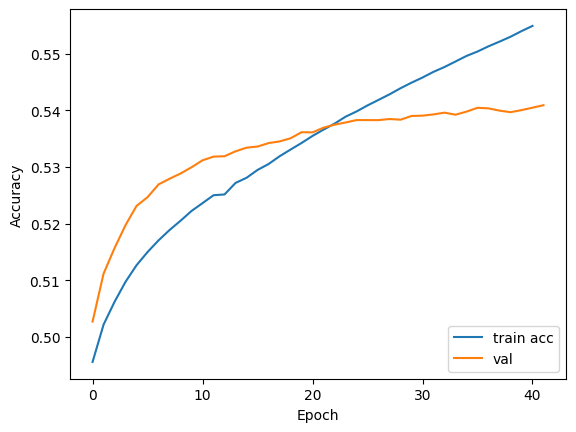

In [84]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

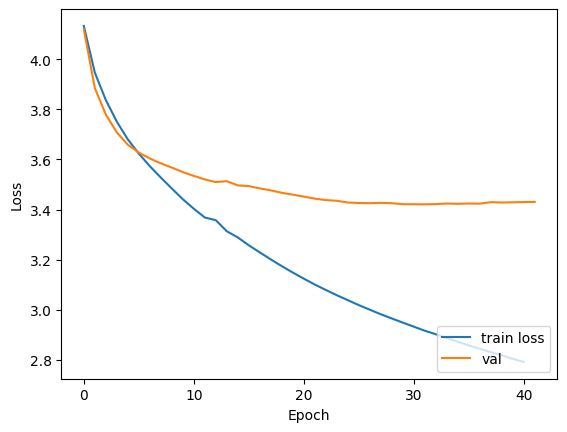

In [85]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [86]:
# Inference
encoder_model, decoder_model = inference_func(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
)

In [87]:
encoder_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 739)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 739, 300)          64202100  
_________________________________________________________________
lstm_3 (LSTM)                [(None, 739, 512), (None, 1665024   
_________________________________________________________________
lstm_4 (LSTM)                [(None, 739, 512), (None, 2099200   
Total params: 67,966,324
Trainable params: 3,764,224
Non-trainable params: 64,202,100
_________________________________________________________________


In [88]:
decoder_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 300)    22051500    input_7[0][0]                    
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 512)]        0                                            
____________________________________________________________________________________________

In [4]:
# Testing on training data
for i in range(0, 10):
    print(f"# {i+1} News: ", seq2text(x_train_padded[i]))
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_func(
            x_train_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()

**Model with Bidirectional LSTMs**

In [90]:
model_func = models_info['bidirectional_lstm']['model']
inference_func = models_info['bidirectional_lstm']['inference']
decode_sequence_func = models_info['bidirectional_lstm']['decode_sequence']

In [91]:
seq2seq = model_func(
    embedding_dim, latent_dim, max_text_len, 
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
)

model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

model.summary()

Model: "seq2seq_model_with_bidirectional_lstm"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 739)]        0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, 739, 300)     64202100    input_11[0][0]                   
__________________________________________________________________________________________________
encoder_bidirectional_lstm_1 (B [(None, 739, 1024),  3330048     encoder_embedding[0][0]          
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, None)]       0                                            
______________________________________________________________

In [5]:
history = model.fit(
    [x_train_padded, y_train_padded[:, :-1]],
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs=num_epochs,
    batch_size=128 #* tpu_strategy.num_replicas_in_sync,
    callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]],
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )
)

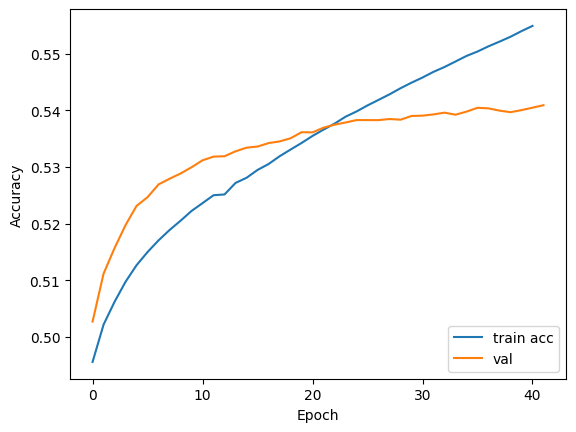

In [93]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

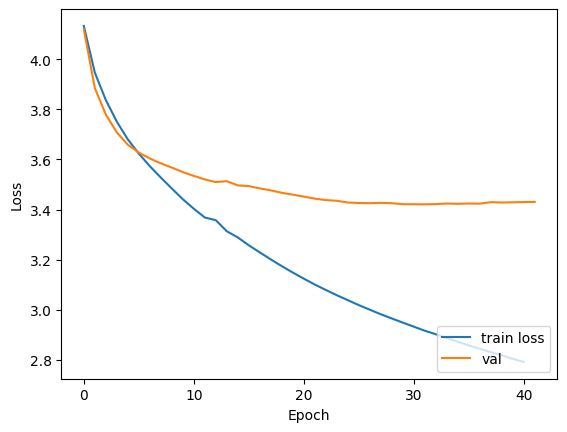

In [94]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [95]:
# Inference
encoder_model, decoder_model = inference_func(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
)

In [96]:
encoder_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 739)]             0         
_________________________________________________________________
encoder_embedding (Embedding (None, 739, 300)          64202100  
_________________________________________________________________
encoder_bidirectional_lstm_1 [(None, 739, 1024), (None 3330048   
_________________________________________________________________
encoder_bidirectional_lstm_2 [(None, 739, 1024), (None 6295552   
_________________________________________________________________
encoder_bidirectional_lstm_3 [(None, 739, 1024), (None 6295552   
Total params: 80,123,252
Trainable params: 15,921,152
Non-trainable params: 64,202,100
_________________________________________________________________


In [97]:
decoder_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, None, 300)    22051500    input_12[0][0]                   
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 512)]        0                                            
____________________________________________________________________________________________

In [98]:
# Testing on training data
for i in range(0, 10):
    print(f"# {i+1} News: ", seq2text(x_train_padded[i]))
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_func(
            x_train_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()

# 1 News:  mailonline reporter new jersey man spark controversy among neighbor fly flag associate jihadist group islamic state say whole thing big misunderstand dunaway garwood say fly flag fridays holy month ramadan years since long isis militants adopt symbol dunaway flag say arabic one god allah prophet muhammad messenger symbol faith every muslim use black flag dunway tell nj com find mosque world american citizen love country also muslim use flag say muslim mr dunaway fly flag outside garwood new jersey home years neighbor recently notice think dunaway support isis jihadists kashmiri dthemonstrators hold flag islamic state dthemonstration israeli military operations gaza although group adopt flag long symbol islam historically associate terrorist group controversy begin tuesday investment manager leibowitz tweet photo flag comment scary jihadists garwood write one commenter photo think right time fly type flag local resident jam mchugh tell news especially go time neighbor diana f

Predicted summary:   elsegood humza conglomerate conglomerate biochthemist perrie borrallo measurthement burtka borrallo borrallo dukakis cernuda taestuary taestuary taestuary taestuary taestuary activision parallel leavin beresfield samoans arniska gopher oe timid bunty bunty bunty galliano compulsory haskin islamists neycaptain mountaintop titswobble unpoliced burkina leverhulme sfu llularised rvp liebschner deng undertaker undertaker undertaker undertaker undertaker undertaker undertaker undertaker basra quilt

# 5 News:  john hall secret underground bunker build protect essential service event nuclear war go hammer bunker construct coswarth cornwall height cold war build experts south west water authority would able maintain water sewerage operations nuclear themergency square foot bunker build house people seven operations room six communications room three control room guide price cold war bunker build design experts south west water authority would able maintain water sewerage o

Predicted summary:   maddison patent picobrew belmond mesaieed douvall hypertension hypertension curbishley uavs occurrence albert albert koch sequinned ludo ves mellons sakurajima lisle creche inger gingrinch gingrinch huan gingrinch hardaker chinas cueto reference calculator razu razu razu razu razu razu razu razu bogotol seagal faletau tranquil grandad montero topless topless topless zlatan furrier witz witz witz witz sarcevic

# 9 News:  cnn residents portion new mexico texas deal thursday rare winter storm foot snow fall south allo texas panhandle national weather service say allo record th snowiest day record date back el paso texas las cruces new mexico accustom wintry dust see usual share white stuff thursday snow continue fall eastern new mexico el paso several road closure school closure announce texas department transportation warn motorists stay roads watch black ice roadways el paso area new mexico state police tweet several road closure crash due whiteout condition notabl

### Model with hybrid architecture

In [99]:
model_func = models_info['hybrid_model']['model']
inference_func = models_info['hybrid_model']['inference']
decode_sequence_func = models_info['hybrid_model']['decode_sequence']

In [100]:
seq2seq = model_func(
    embedding_dim, latent_dim, max_text_len, 
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
)

model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

model.summary()

Model: "seq2seq_model_with_bidirectional_lstm"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 739)]        0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, 739, 300)     64202100    input_18[0][0]                   
__________________________________________________________________________________________________
encoder_bidirectional_lstm_1 (B [(None, 739, 1024),  3330048     encoder_embedding[0][0]          
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, None)]       0                                            
______________________________________________________________

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [ ]:
# Inference
encoder_model, decoder_model = inference_func(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
)

In [ ]:
encoder_model.summary()

In [ ]:
decoder_model.summary()

In [ ]:
# Testing on training data
for i in range(0, 10):
    print(f"# {i+1} News: ", seq2text(x_train_padded[i]))
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_func(
            x_train_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()